In [2]:
%matplotlib inline
import warnings   

import os
import pandas as pd
import sys
import glob
import json
import time

import nibabel as nib
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
from scipy.ndimage import morphology
from scipy.signal import convolve

# Import data science modules
from scipy import interp, ndimage

# Import graphing modules
import matplotlib
import matplotlib.pyplot as plt

# Import machine learning modules
from sklearn import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.tree import *
from sklearn.externals import joblib

sys.path.append(os.path.expanduser('~/gdrive/aim3/code'))
from Echobase.Common import errors
from Echobase.Network.Metrics.globaltopo import synchronizability
from Echobase.Network.Transforms import lesion
from Echobase.Pipelines.ecog_network import *


with open(os.path.expanduser('~/gdrive/aim3/code/data/DATA.json')) as json_data_file:
    data = json.load(json_data_file)

def gather_cres_results(dilate_radius, fconn = 'highgamma'):
    '''
    Utility function to output a dictionary of all results.

    Parameters
    ----------
        dilate_radius: str,
            Dilation radius

        fconn: str,
            Connectivity metric
    Returns
    -------
        results: dict,
            Results that contain as key patient id, and has as value another dictionary with cres for given dilation radius in each clip.
    '''
    # All cres
    results = {}

    for patient_id in os.listdir(os.path.expanduser(data['COMP_DIR'])):
        if(patient_id == 'TEST1'):
            continue

        comp_dir = os.path.join(os.path.expanduser(data['COMP_DIR']),patient_id,'aim3')

        # Find pipedef file
        for fn in os.listdir(comp_dir):
            if('pipedef' in fn):
                # Open pipedef
                pipedef = json.load(open('%s/%s'%(comp_dir,fn),'r'))
                # determine if correction dilation
                if(np.float(pipedef['dilate_radius']) == np.float(dilate_radius)):
                    unique_id = fn.split('.')[4]
                    results[patient_id] = {}
                    break

        # Open all cres
        try:
            for fn in os.listdir(comp_dir):
                if('cres.%s'%(unique_id) in fn and 'pipedef' not in fn):
                    clip_id = fn.split('.')[2]
                    seizure_type = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
                    if('CPS' not in seizure_type and seizure_type != '??'):
                        continue
                    results[patient_id][clip_id] = np.load('%s/%s'%(comp_dir,fn))['control_centrality_%s'%fconn]
        except:
            continue

    return results

def gather_cnonres_results(dilate_radius, fconn = 'highgamma'):
    '''
    Utility function to output a dictionary of all results.

    Parameters
    ----------
        dilate_radius: str,
            Dilation radius

        fconn: str,
            Connectivity metric
    Returns
    -------
        results: dict,
            Results that contain as key patient id, and has as value another dictionary with cres for given dilation radius in each clip.
    '''
    # All cres
    results = {}

    for patient_id in os.listdir(os.path.expanduser(data['COMP_DIR'])):
        if(patient_id == 'TEST1'):
            continue

        comp_dir = os.path.join(os.path.expanduser(data['COMP_DIR']),patient_id,'aim3')

        # Find pipedef file
        for fn in os.listdir(comp_dir):
            if('pipedef' in fn):
                # Open pipedef
                pipedef = json.load(open('%s/%s'%(comp_dir,fn),'r'))
                # determine if correction dilation
                if(np.float(pipedef['dilate_radius']) == np.float(dilate_radius)):
                    unique_id = fn.split('.')[4]
                    results[patient_id] = {}
                    break

        # Open all cres
        try:
            for fn in os.listdir(comp_dir):
                if('cres.%s'%(unique_id) in fn and 'pipedef' not in fn):
                    clip_id = fn.split('.')[2]
                    seizure_type = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
                    if('CPS' not in seizure_type and seizure_type != '??'):
                        continue
                    results[patient_id][clip_id] = np.load('%s/%s'%(comp_dir,fn))['non_control_centrality_%s'%fconn]
        except:
            continue

    return results

def gather_base_sync_results(dilate_radius, fconn = 'highgamma'):
    '''
    Utility function to output a dictionary of all results.

    Parameters
    ----------
        dilate_radius: str,
            Dilation radius

        fconn: str,
            Connectivity metric
    Returns
    -------
        results: dict,
            Results that contain as key patient id, and has as value another dictionary with cres for given dilation radius in each clip.
    '''
    # All cres
    results = {}

    for patient_id in os.listdir(os.path.expanduser(data['COMP_DIR'])):
        if(patient_id == 'TEST1'):
            continue

        comp_dir = os.path.join(os.path.expanduser(data['COMP_DIR']),patient_id,'aim3')

        # Find pipedef file
        for fn in os.listdir(comp_dir):
            if('pipedef' in fn):
                # Open pipedef
                pipedef = json.load(open('%s/%s'%(comp_dir,fn),'r'))
                # determine if correction dilation
                if(np.float(pipedef['dilate_radius']) == np.float(dilate_radius)):
                    unique_id = fn.split('.')[4]
                    results[patient_id] = {}
                    break

        # Open all cres
#         print 'fconn: %s, Dilation Radius: %s, PatientID: %s, uid: %s'%(fconn, dilate_radius, patient_id, unique_id)
        try:
            for fn in os.listdir(comp_dir):
                if('cres.%s'%(unique_id) in fn and 'pipedef' not in fn):
                    clip_id = fn.split('.')[2]
                    seizure_type = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
                    if('CPS' not in seizure_type and seizure_type != '??'):
                        continue
                    results[patient_id][clip_id] = np.load('%s/%s'%(comp_dir,fn))['base_sync_%s'%fconn]
        except:
            continue

    return results

def gather_adj_results(fconn = 'highgamma'):
    '''
    Utility function to output a dictionary of all results.

    Parameters
    ----------
        dilate_radius: str,
            Dilation radius

        fconn: str,
            Connectivity metric
    Returns
    -------
        results: dict,
            Results that contain as key patient id, and has as value another dictionary with cres for given dilation radius in each clip.
    '''
    # All cres
    results = {}

    for patient_id in os.listdir(os.path.expanduser(data['COMP_DIR'])):
        if(patient_id == 'TEST1'):
            continue

        comp_dir = os.path.join(os.path.expanduser(data['COMP_DIR']),patient_id,'aim3')

        # Open all adj
        try:
            for fn in os.listdir(comp_dir):
                if('multiband' in fn):
                    if(patient_id not in results.keys()):
                        results[patient_id] = {}
                    print fn
                    clip_id = fn.split('.')[2]
                    
                    seizure_type = data['PATIENTS'][patient_id]['Events']['Ictal'][clip_id]['SeizureType']
                    if('CPS' not in seizure_type and seizure_type != '??'):
                        continue
                    results[patient_id][fn.split('.')[2]] = np.load('%s/%s'%(comp_dir,fn))['all_adj_%s'%fconn]
        except:
            print fn+'!!!!'
            continue

    return results

def get_outcome(outcome):
    """
    Function for determing poor and favorable surgical outcome.
    Parameters
    ----------
        outcome: str
            Surgical outcome as either Engel or ILAE.

    Returns
    -------
        str
            Returns either good or bad.
    """
    switcher = {
        '1': 'Good',
        '1.1': 'Good',
        '1.2': 'Good',
        '1.3': 'Good',
        '1.4': 'Good',
        '1A': 'Good',
        '1B': 'Good',
        '1C': 'Good',
        '1D': 'Good',
        'IA': 'Good',
        'IB': 'Good',
        'IC': 'Good',
        'ID': 'Good',
        '2': 'Poor',
        '2.1': 'Poor',
        '2.2': 'Poor',
        '2.3': 'Poor',
        '2.4': 'Poor',
        '2a': 'Poor',
        '2b': 'Poor',
        '2c': 'Poor',
        '2d': 'Poor',
        '3': 'Poor',
        '4': 'Poor',
        'II': 'Poor',
        'III': 'Poor',
        'IV': 'Poor',
        'ILAE1': 'Good',
        'ILAE2': 'Good',
        'ILAE3': 'Poor',
        'ILAE4': 'Poor',
        'ILAE5': 'Poor'
    }

    return switcher.get(outcome, "Good")

def get_warning():
    warnings.warn("deprecated",DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    get_warning()
    warnings.simplefilter("ignore")


/gdrive/public/USERS/lkini/thesis/ec2/anaconda2/envs/echobase/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/gdrive/public/USERS/lkini/thesis/ec2/anaconda2/envs/echobase/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/gdrive/public/USERS/lkini/thesis/ec2/anaconda2/envs/echobase/lib/python2.7/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.Line

<h1>Generate feature matrix csv </h1>

In [136]:
for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma']:
        dilate_radius = 0
        all_base_sync = gather_base_sync_results(dilate_radius,fconn)
        
        skip_chop = False
        skip_mayo = False
        skip_hup = False

        pt_iter = 0

        patient_idx = all_base_sync.keys()
        if(skip_chop):
            ft_matrix = np.zeros((20,900+2))
        else:
            ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_base_sync.values())),900+2))
        out_txt = 'pt_id,' #First column
        index_col = []    

        for patient_id in sorted(patient_idx):
                print patient_id
                if(skip_chop and 'CHOP' in patient_id):
                    continue
                if(skip_mayo and 'Study' in patient_id):
                    continue
                if(skip_hup and 'HUP' in patient_id):
                    continue
                if not all_base_sync[patient_id]:
                    continue
                index_col.append(patient_id)
                row_data = np.array((pt_iter+1,))    
                for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):                    
                    if(pid != patient_id):
                        continue
                    outcome = data['PATIENTS'][patient_id]['Outcome']

                    avg_data = np.array(())                    
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        res = clip_data                        
                        if(res.shape[0] == 901):
                            res = res[:900]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(900,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(900,1))                    
                    avg_data = np.nanmedian(avg_data,axis=1)

                    # Update row_data
                    row_data = np.hstack((row_data,avg_data)) 

                    # Update header
                    if(pt_iter == 0):
                        for t in range(1,901):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.hstack((row_data,[0]))        
                else:
                    row_data = np.hstack((row_data,[1]))
                if(row_data.shape[0] != 900+2):
                    continue
                ft_matrix[pt_iter,:] = row_data
                pt_iter += 1
        out_txt += 'Outcome'

        df = pd.DataFrame(data=ft_matrix, index=index_col,columns=out_txt.split(',') )

        comp_dir = os.path.expanduser(data['COMP_DIR'])
        df.to_csv('%s/../code/data/e01A_%s.csv'%(comp_dir,fconn))

fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP065, uid: 6cf700ce-df4c-4a2d-b32a-4367c0fa6321
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP064, uid: d6437385-2757-460d-a334-dbb49dc93797
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP068, uid: 37db3000-f44a-4563-803a-d7cac43013d4
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP070, uid: 5b3c61e9-3860-428b-85fa-497b4d2f2463
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP073, uid: 0a7208bf-3add-4972-94b5-dac166aaf349
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP074, uid: 1aef7aaf-d4ac-4ed0-a20d-3b342a0d8fb3
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP075, uid: c567a5fa-0d59-4f2e-93ab-3664ac556ecd
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP078, uid: 8b93428a-415a-4162-ba70-e72d95c05990
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP080, uid: a345a589-1621-4e18-bf2b-615b42be525b
fconn: broadband_CC, Dilation Radius: 0, PatientID: HUP082, uid: 1c31d3da-fe59-4fa

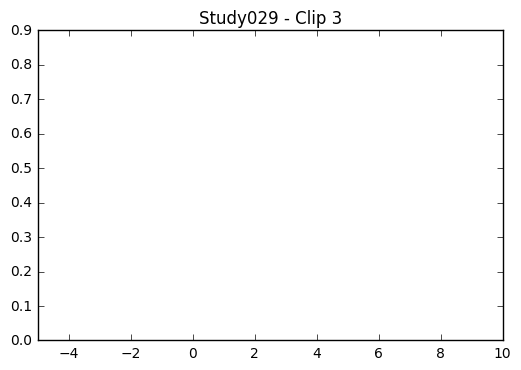

In [3]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

fconn = 'broadband_CC'
dilate_radius = 0
all_base_sync = gather_base_sync_results(dilate_radius,fconn)

skip_chop = False
skip_mayo = False
skip_hup = False

pt_iter = 0

patient_idx = all_base_sync.keys()
out_txt = 'pt_id,' #First column
index_col = []    
outcomex = []
labels = []
all_data = np.array(())
for patient_id in sorted(patient_idx):
#             print patient_id
        if(skip_chop and 'CHOP' in patient_id):
            continue
        if(skip_mayo and 'Study' in patient_id):
            continue
        if(skip_hup and 'HUP' in patient_id):
            continue
        if not all_base_sync[patient_id]:
            continue
        index_col.append(patient_id)
        row_data = np.array((pt_iter+1,))
        for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):                    
            if(pid != patient_id):
                continue
            outcome = data['PATIENTS'][patient_id]['Outcome']
            
            for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                res = clip_data
                if(res.shape[0] == 901):
                    res = res[:900]
                try:                
                    all_data = np.hstack((all_data,np.reshape(res,(900,1))))
                except Exception:                
                    all_data = np.reshape(res,(900,1))   
                if(get_outcome(outcome) == 'Good'):        
                    outcomex.append(0)
                else:
                    outcomex.append(1)
                labels.append('%s - Clip %s'%(pid, clip))
outcomex = np.array(outcomex)
labels = np.array(labels)
all_data = all_data.T

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(( -5.0, 10.0))
ax.set_ylim((0, 0.9))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(-5.0, 10.0-1/60.0,900)
    y = all_data[i,:]
    line.set_data(x, y)
    if(outcomex[i] == 1):
        line.set_color('red')
    else:
        line.set_color('blue')   
    line.set_alpha(0.2)
    ax.set_title(labels[i])
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
plt.hold(True)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=197, interval=200, blit=False)
anim
# anim.save('../fig/e01A_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

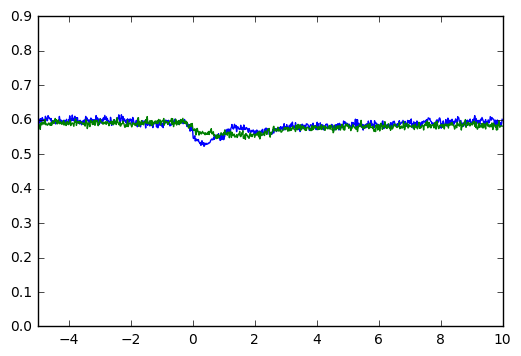

In [64]:
plt.plot(np.arange(-5.0,10.0,1/60.0),np.nanmean(all_data[outcomex==0,:],axis=0))
plt.hold(True)
plt.plot(np.arange(-5.0,10.0,1/60.0),np.nanmean(all_data[outcomex==1,:],axis=0))
plt.xlim(( -5.0, 10.0))
plt.ylim((0, 0.9))

plt.show()

<h1> e01A. Cross-Validation using basic connectivity features </h1>

Generating feature matrix ...
(27, 900)
Feature reduction to 5 features ...
Performing cross validation ...
Computing AUC of ROC ...


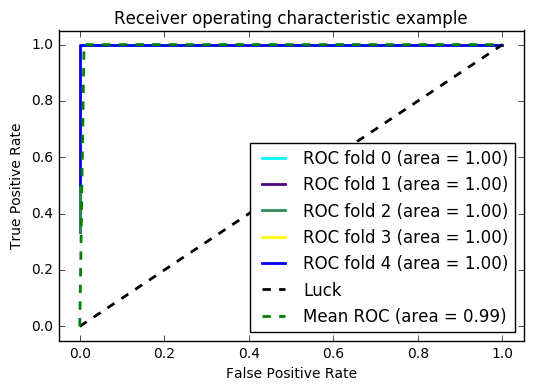

Mean AUC: 0.995 $\pm$ 0.071


In [205]:
rs = 25
# Parameters
k1 = 5 # Number of features remaining after first round of feature reduction
# k2 = 350 # Number of features remaining after second round of feature reduction

# Load DataFrame
# Load DataFrame
# df1 = pd.read_csv('~/gdrive/aim3/code/data/e01A_broadband_CC.csv')
df2 = pd.read_csv('~/gdrive/aim3/code/data/e01A_alphatheta.csv')
# df3 = pd.read_csv('~/gdrive/aim3/code/data/e01A_beta.csv')
# df4 = pd.read_csv('~/gdrive/aim3/code/data/e01A_lowgamma.csv')
# df5 = pd.read_csv('~/gdrive/aim3/code/data/e01A_highgamma.csv')
# df = pd.concat([df1, df2, df3, df4, df5],axis=1)
df = df2

if(True):
    df = df.dropna()

# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
X = np.array(df[df.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
print X.shape
# y = np.array(df.Outcome.iloc[:,0])
y = np.array(df.Outcome)


if(False):
    imp = Imputer(missing_values = 'NaN', strategy='mean', axis=0)
    X = imp.fit(X).transform(X)    

# Build a Random Forest with 1000 estimators
classifier_VR = RandomForestClassifier(n_estimators=1000, random_state=rs)

# Perform the first prune using ANOVA F test using mutual information
print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
X = prune1.fit_transform(X,y)

# # Perform a second prune by selecting features optimally branched using the classifier
# print 'Second round of feature reduction ...'
# clf = classifier_VR.fit(X,y)
# model = SelectFromModel(clf, prefit=True)
# X = model.transform(X)

# # Generate polynomial (degree 2) with interaction term feature set to account 
# # for non-linear combinations.
# # This will include cross-interaction terms to take into account non-linear combinations 
# # of clinical variables.
# print 'Generating polynomial combination of features ...'
# poly = PolynomialFeatures(2)
# X = poly.fit_transform(X)

# # Perform the third prune using ANOVA F test using mutual information
# print 'Final round of feature reduction to %i features ...'%k2
# prune2 = SelectKBest(mutual_info_classif, k=k2)
# X = prune2.fit_transform(X,y)

# Compute 8-fold cross-validation True Positive Rate (TPR) and False Positive Rate (FPR)
# to generate ROC curves.
print 'Performing cross validation ...'
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=rs)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

from itertools import cycle
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2
i = 0

# for (train, test) in cv.split(X,y):
for (train, test), color in zip(cv.split(X, y), colors):
    # Ignore any folds that do not have any poor outcomes 
    # to maintain representation of entire dataset.
    if(sum(y[test]) == 0):
        print train,test
        continue
    probas_ = classifier_VR.fit(X[train], y[train]).predict_proba(X[test])
    
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.hold(True)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',label='Luck')

# Compute mean Area Under Curve (AUC)    
print 'Computing AUC of ROC ...'
mean_tpr /= n_splits
mean_tpr[-1] = 1.0
mean_auc_VR = auc(mean_fpr, mean_tpr)
sigma_auc_VR = 2*np.sqrt(mean_auc_VR*(1-mean_auc_VR)/4)

plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc_VR, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Compute Mean AUC and Confidence interval using \sigma_max
print "Mean AUC: %0.3f $\pm$ %0.3f"%(mean_auc_VR,sigma_auc_VR)

<h2> Create developmental and validation cohorts </h2>

In [213]:
# Load DataFrame
# df1 = pd.read_csv('~/gdrive/aim3/code/data/e01A_broadband_CC.csv')
# df2 = pd.read_csv('~/gdrive/aim3/code/data/e01A_alphatheta.csv')
# cols_to_use = df2.columns.difference(df1.columns)
# df = pd.merge(df1, df2[cols_to_use], left_index=True, right_index=True, how='outer')

# df3 = pd.read_csv('~/gdrive/aim3/code/data/e01A_beta.csv')
# cols_to_use = df3.columns.difference(df.columns)
# df = pd.merge(df, df3[cols_to_use], left_index=True, right_index=True, how='outer')

# df4 = pd.read_csv('~/gdrive/aim3/code/data/e01A_lowgamma.csv')
# cols_to_use = df4.columns.difference(df.columns)
# df = pd.merge(df, df4[cols_to_use], left_index=True, right_index=True, how='outer')

# df5 = pd.read_csv('~/gdrive/aim3/code/data/e01A_highgamma.csv')
# cols_to_use = df5.columns.difference(df.columns)
# df = pd.merge(df, df5[cols_to_use], left_index=True, right_index=True, how='outer')
df2 = pd.read_csv('~/gdrive/aim3/code/data/e01A_alphatheta.csv')
df = df2

df = df.dropna()

# Determine randomly generated train and test split 
rs = ShuffleSplit(n_splits=1, test_size= 0.33)
for train_index, test_index in rs.split(df['Unnamed: 0']):
    train = train_index
    test = test_index

train_ptx = ['Study017','HUP083','CHOP42','CHOP45','CHOP20','CHOP08','CHOP43','CHOP40','Study016','Study020','CHOP46','HUP078','HUP073','HUP075','Study012','HUP070','Study022']
test_ptx = ['CHOP47','CHOP27','HUP080','Study029','Study028','HUP086','HUP074','HUP082','Study019']
train = []
test = []
for ii, pt in enumerate(df['Unnamed: 0']):
    if(pt in train_ptx):
        train.append(ii)
    elif(pt in test_ptx):
        test.append(ii)
             
#train = [19, 23, 16, 17, 13, 11, 21, 20, 18, 1, 9, 4, 7, 6, 15, 8,  0]
#test = [10, 12, 25,  2,  3, 22,  5, 24, 14]
train_idx = df.iloc[train,:]['Unnamed: 0']
test_idx = df.iloc[test,:]['Unnamed: 0']
print train_idx, test_idx, df.iloc[test,:].Outcome


0       CHOP08
2       CHOP20
8       CHOP45
9       CHOP46
14      HUP073
16      HUP075
17      HUP078
20      HUP083
24    Study012
25    Study016
26    Study017
28    Study020
29    Study022
Name: Unnamed: 0, dtype: object 3       CHOP27
10      CHOP47
15      HUP074
18      HUP080
19      HUP082
21      HUP086
27    Study019
30    Study028
31    Study029
Name: Unnamed: 0, dtype: object 3     0.0
10    0.0
15    0.0
18    1.0
19    0.0
21    1.0
27    1.0
30    1.0
31    1.0
Name: Outcome, dtype: float64


<h2> Create the feature matrix $X$ and target outcome $y$ for all 4 models </h2>

In [214]:
df4 = df

# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
df4_train_idx = np.where(df4['Unnamed: 0'].isin(train_idx))
df4_test_idx = np.where(df4['Unnamed: 0'].isin(test_idx))
X4 = np.array(df4[df4.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
y4 = np.array(df4.Outcome)
X4_labels = df4.columns.difference(['Unnamed: 0','pt_id','Outcome'])

Generating feature matrix ...


<h3> Perform feature reduction for each model</h3>

In [215]:
# Parameters
k1 = 5 # Number of features remaining after first round of feature reduction
# k2 = 350 # Number of features remaining after second round of feature reduction

# Build a Random Forest with 5000 estimators
classifier4 = RandomForestClassifier(n_estimators=1000)

## Do feature reduction on Model 4
print 'Model 4 ..................'
X = np.copy(X4)
y = np.copy(y4)

# Perform the first prune using ANOVA F test using mutual information
print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
X = prune1.fit_transform(X,y)
X4_labels = X4_labels[prune1.get_support()]
X4_pruned = X

# # Perform a second prune by selecting features optimally branched using the classifier
# print 'Second round of feature reduction ...'
# clf = classifier4.fit(X,y)
# model = SelectFromModel(clf, prefit=True)
# X = model.transform(X)
# X4_labels = X4_labels[model.get_support()]

# # Generate polynomial (degree 2) with interaction term feature set to account 
# # for non-linear combinations.
# # This will include cross-interaction terms to take into account non-linear combinations 
# # of clinical variables.
# print 'Generating polynomial combination of features ...'
# poly = PolynomialFeatures(2)
# X = poly.fit_transform(X)
# X4_labels = np.array(poly.get_feature_names(X4_labels))

# # Perform the third prune using ANOVA F test using mutual information
# print 'Final round of feature reduction to %i features ...'%k2
# prune2 = SelectKBest(mutual_info_classif, k=k2)
# X = prune2.fit_transform(X,y)
# X4_pruned = X
# X4_labels = X4_labels[prune2.get_support()]

Model 4 ..................
Feature reduction to 5 features ...


<h3> Measure ROC and plot </h3>

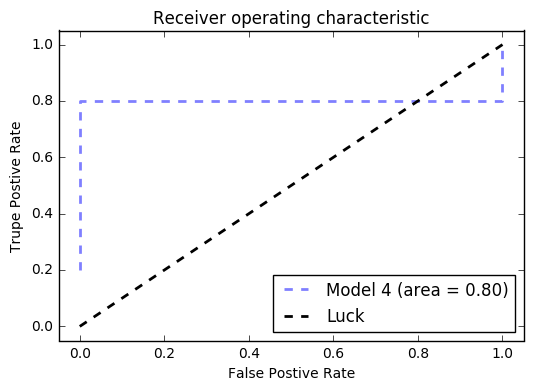

In [216]:
colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange']
lw = 2

# Train and test Model 4
X4_train = np.squeeze(X4_pruned[df4_train_idx,:])
y4_train = y4[df4_train_idx]
X4_test = np.squeeze(X4_pruned[df4_test_idx,:])
y4_test = y4[df4_test_idx]
y4_hat = classifier4.fit(X4_train,y4_train).predict_proba(X4_test)
fpr, tpr, thresholds = roc_curve(y4_test,y4_hat[:,1])
roc_auc = auc(fpr, tpr)
i = 4
plt.plot(fpr, tpr, lw=lw, color=colors[i], linestyle='--', label = 'Model %d (area = %0.2f)'%(i,roc_auc), alpha=0.5)
# Save Model 4 for model persistence
# joblib.dump(classifier4, 'classifier4.pkl')

# Plot the ROC curve for luck along with area
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Receiver operating characteristic')
plt.xlabel('False Postive Rate')
plt.ylabel('Trupe Postive Rate')
plt.legend(loc="lower right")
plt.show()

In [217]:
train_idx, test_idx, df4['Unnamed: 0'].iloc[df4_test_idx], y4_hat, y4_test

(0       CHOP08
 2       CHOP20
 8       CHOP45
 9       CHOP46
 14      HUP073
 16      HUP075
 17      HUP078
 20      HUP083
 24    Study012
 25    Study016
 26    Study017
 28    Study020
 29    Study022
 Name: Unnamed: 0, dtype: object, 3       CHOP27
 10      CHOP47
 15      HUP074
 18      HUP080
 19      HUP082
 21      HUP086
 27    Study019
 30    Study028
 31    Study029
 Name: Unnamed: 0, dtype: object, 3       CHOP27
 10      CHOP47
 15      HUP074
 18      HUP080
 19      HUP082
 21      HUP086
 27    Study019
 30    Study028
 31    Study029
 Name: Unnamed: 0, dtype: object, array([[ 0.641,  0.359],
        [ 0.686,  0.314],
        [ 0.554,  0.446],
        [ 0.411,  0.589],
        [ 0.714,  0.286],
        [ 0.494,  0.506],
        [ 0.203,  0.797],
        [ 0.759,  0.241],
        [ 0.347,  0.653]]), array([ 0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.]))

<h1> Feature Learning </h1>

In [118]:
# Compute feature importances
clf4 = classifier4

def _helper(job):
    '''
    This helper function runs one instance of model fitting and returns the top feature importances and their name.
    '''    
    classifier,X_labels,all_labels,importances,K = job
    print K
    # Sort feature importances
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier4.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print all feature importances
    fnames = []
    for f in range(K):
        fname = X4_labels[indices[f]]
        fnames.append((fname,importances[indices[f]]))
        return fnames

    
# Parallel version
n_iter = 100
K = 4500
    
def run_jobs(clf, X_train, y_train, X_labels, all_labels, K):
    '''
    This function runs n_iter instances of model fitting and keeps track of the top $K$ features. 
    This function uses multiple cores to speed up computation.
    '''
    jobs = []
    
    for n in range(n_iter):
        print n
        clf.fit(X_train, y_train)
        importances = clf.feature_importances_
        classifier = clf    
        jobs.append((classifier,X_labels,all_labels,importances,K))
    return jobs
    return_list = []
    n_proc = 40
    pool = Pool(n_proc)
    return_list = map(_helper, jobs)
    pool.close()
    return return_list

clf = clf4
X_train = X4_train
y_train = y4_train
X_labels = X4_labels
all_labels = df4.columns.difference(['Unnamed: 0','id','outcome_binary'])
return_list4 = run_jobs(clf, X_train, y_train, X_labels, all_labels, K)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [125]:
jobs = return_list4
all_importances = []
for job in jobs:
    all_importances.append(job[3])
all_importances = np.array(all_importances)
print all_importances.shape
importances = np.mean(all_importances,axis=0)
indices = np.argsort(importances)[::-1]

# Print all feature importances
fnames = []
for f in range(K):
    fname = X4_labels[indices[f]]
    fnames.append((fname,importances[indices[f]]))
lines = []
for fname, val in fnames:
    lines.append('%s,%s'%(fname,val))

(100, 4500)


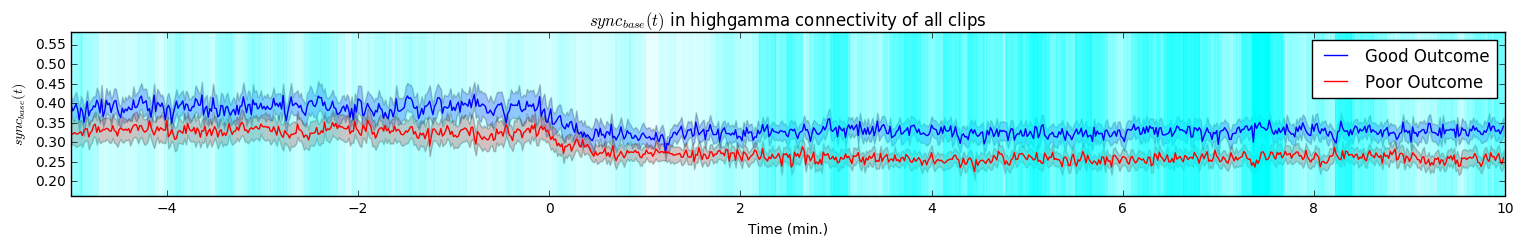

In [218]:
import sys
import glob
import json
import time

for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma']:
    skip_chop = False
    skip_mayo = False
    skip_hup = False
    window = 1
    
    # Load DataFrame
    df = pd.read_csv('~/gdrive/aim3/code/data/e01A_%s.csv'%fconn)
    
    good = np.array(df[df.Outcome==0][sorted(df.columns.difference(['Unnamed: 0','Outcome','pt_id']),key=lambda x: int(x.split('_')[2]))]).T
    poor = np.array(df[df.Outcome==1][sorted(df.columns.difference(['Unnamed: 0','Outcome','pt_id']),key=lambda x: int(x.split('_')[2]))]).T

    times = np.arange(-300.0,600,window)*1.0/60

    base_sync = []
    for k in good:
        base_sync.append(np.nanmean(k[~np.isnan(k)]))
#     base_sync = base_sync[:-1]    
    
    error = scipy.stats.sem(good.T,nan_policy='omit')    
#     error = error[:-1]
#     print len(base_sync), times.shape, error.shape
    plt.plot(times,base_sync,'b-')
    plt.fill_between(times,base_sync-error,base_sync+error,facecolor='blue',alpha=0.25)
    plt.hold(True)

    base_sync = []
    for k in poor:
        base_sync.append(np.nanmean(k[~np.isnan(k)]))
#     base_sync = base_sync[:-1]
    error = scipy.stats.sem(poor.T,nan_policy='omit')
#     error = error[:-1]
    plt.plot(times,base_sync,'r-')
    plt.fill_between(times,base_sync-error,base_sync+error,facecolor='red',alpha=0.25)
    
    ##### PROCESS CSV RF FEATS
#     lines = open(os.path.expanduser('~/gdrive/tmp/aim3/rf_feats.csv'),'r').readlines()
    max_val = np.max(map(lambda x: float(x.split(',')[1]),lines))
    for line in lines:
        ft = line.split(',')[0]
        val = float(line.split(',')[1])
#         print ft,val
        ft_time = int(ft.split('_')[2])
        ft_fconn = ft.split('_')[3]
        if(ft_fconn == fconn or ft_fconn in fconn):
#             print fconn, ft_fconn, ft_time,val
            plt.fill_between([(ft_time-5-300)/60.0, (ft_time+5-300)/60.0], np.min(base_sync-error)-np.abs(np.min(base_sync-error))*0.2, np.max(base_sync+error)+np.abs(np.max(base_sync+error))*0.5, facecolor=(val,1-val,1-val),edgecolor=(val,1-val,1-val),alpha=min(val/max_val,1))
            pass
        

    # plt.xticks(map(lambda x: x+1, range(times.shape[0]))[::2],times[::2])
    # plt.yticks([])
    plt.xlabel('Time (min.)')
    plt.ylabel('$sync_{base}(t)$')
    plt.xlim([-5.0,10.0])
    plt.ylim([np.min(base_sync-error)-np.abs(np.min(base_sync-error))*0.2, np.max(base_sync+error)+np.abs(np.max(base_sync+error))*0.5])
    plt.title('$sync_{base}(t)$ in %s connectivity of all clips'%(fconn))
    plt.legend(['Good Outcome','Poor Outcome'])
#     plt.show()
    fig = plt.gcf()
    fig.set_size_inches(18.5,2.11)
    fig.savefig(os.path.expanduser('~/gdrive/aim3/fig/e01A.ROZ_delta_clip_%s_with_fts.png'%(fconn)),dpi=100,bbox_inches='tight')
    plt.hold(False)